In [2]:
%matplotlib inline

from __future__ import division
import os
import sys
from scipy import integrate, optimize
from scipy.interpolate import interp2d, interp1d

import numpy as np
from numpy import pi,sin,cos,tan,e,arctan,arcsin,arccos,sqrt
from numpy.random import randn
import matplotlib
import matplotlib.pyplot as P
from time import clock


matplotlib.rcParams['figure.figsize'] = (7, 5)
P.rcParams['text.usetex'] = True  # not really needed
P.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
P.rcParams["font.size"] = 24
P.rc('xtick', labelsize=18) 
P.rc('ytick', labelsize=18)
# P.rc('xtick', labelsize=20) 
# P.rc('ytick', labelsize=20)
np.set_printoptions(threshold=np.nan)


# sys.path.append("/Users/amadeus/Documents/10.semester/ma")
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, W_tophat, T_obs, nutoz21, h
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, T_obs, nutoz21, h
from magmod import *
from magbias_experiments import SKA_zhangpen, CLAR_zhangpen, SKA, cb_hirax as hirax, hirax512, LSST, n


sigma_8_BBKS = 0.833959881058


In [3]:
plotdir = "./plots/"



# #preliminary, to be changed!!
# bHI = 1
# bgal = 1

lmin = 250; lmax = 30000 # lmin and lmax for Cl calculation
# lmin = 1; lmax = 1000 # lmin and lmax for Cl calculation
# ltab = np.arange(lmin,lmax)
# ltab = np.arange(lmin,lmax, 1000)
ltab = np.logspace(np.log10(lmin), np.log10(lmax), 25, dtype = int)
# ltab = np.array([280])

################################################
# ZhangPen:
zf = 0.75
dzf = 0.25
zfmin = zf - dzf; zfmax = zf + dzf

zb = (1.5 + 1.9)/2
dzb = 1.9 - zb
zbmin = zb - dzb; zbmax = zb + dzb
################################################



# ################################################
# zf = 0.3
# dzf = 0.005
# zfmin = zf - dzf; zfmax = zf + dzf

# zb = 1.5
# dzb = 0.01
# zbmin = zb - dzb; zbmax = zb + dzb
# ################################################



# zf = .1
# dzf = 0.06
# zfmin = zf - dzf; zfmax = zf + dzf

# zb = .4
# dzb = 0.06
# zbmin = zb - dzb; zbmax = zb + dzb

print "foreground from {} to {}".format(zfmin, zfmax)
print "background from {} to {}".format(zbmin, zbmax)



foreground from 0.5 to 1.0
background from 1.5 to 1.9


From ZiourHui:

In [4]:
#two ways to compute the same thing:




def Cl_delkap2_CAMB(ltable, zf, zb, delta_zf, Nint = 500):
    fac = bHI * (5*sg(zb) - 2)
    return Cl_HIxmag_CAMB(ltable, zf, zb, delta_zf, Nint = Nint) / fac

def Cl_delkap_CAMB(ltable, zf, zb, delta_zf, Nint = 500):
    fac = 3/2 * (H_0/c)**2 * Omega_m
    
    zmin = zf - delta_zf
    zmax = zf + delta_zf
    ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf
#     gtab = [g(zz, zb, dzb) for zz in ztab] # this is slow
    gtab = g(ztab, zb, dzb)
    
    integrand=np.zeros([len(ztab),len(ltable)])
    for il in range(len(ltable)):
        ell = ltable[il]
        integrand[:,il]= [(1+zzz) * W_tophat(zzz, zfmin, zfmax) * gtab / rCom(zzz)**2 * pknl(( ell)/rCom(zzz), zzz) for zzz in ztab]
    result= fac * np.trapz(integrand,ztab,axis=0)
    return result

Now we reproduce Fig 1 and 2 successfully (just adjust survey area and experiment accordingly):

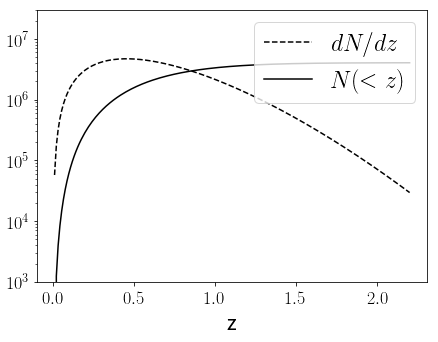

In [5]:
ztab = np.linspace(0.01, 2.2,200)
nsig=4
Flux = n * Ssys(ztab, CLAR_zhangpen) #we require an n-sigma detection


dNdztab = dNdz(ztab, nsig, CLAR_zhangpen)
Ntab = N_HI(ztab, nsig, CLAR_zhangpen)

fig = P.figure(); ax = fig.add_subplot(111);
ax.semilogy(ztab, dNdztab, ls = "--", color = "black", label = r"$dN/dz$" )
ax.semilogy(ztab, Ntab, color = "black", label = r"$N(<z)$")

ax.set_ylim((1e3, 3e7))
ax.set_xlabel("z")

P.legend(loc = "upper right")



We were not able to calculate $\alpha$ as in the zhang&pen paper, so we simply fit a curve to their figures. 


From arXiv:0706.1071 equation A9: $s = \frac{d\log_{10} n_g}{dm}$ with the magnitude threshold $m = -2.5 \log_{10} F$. Therefore we have $s = -\frac{5}{2} \frac{d\log_{10} n_g}{d\log_{10}F} = \frac{5}{2} \alpha$

Thus we can also use the $s_g$ we used for Alkistis HIxmag Cls to get $\alpha$.

To test, we plot our fit for $\alpha$:

Caution, s_g is implemented without dependence on the experiment


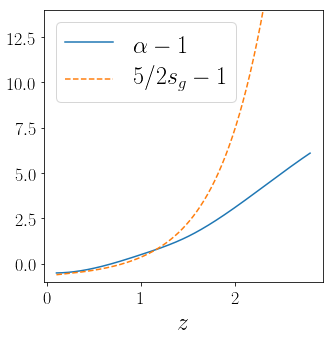

In [6]:
#now plot s :

z = np.linspace(0.1, 2.8, 500)

Ftab = nsig * Ssys(z, CLAR_zhangpen)
mtab = -2.5 * np.log10(Ftab)

fig = P.figure(figsize = (5,5));
ax2 = fig.add_subplot(111)


ax2.plot(z, alpha(z, CLAR_zhangpen)-1, label = r"$\alpha-1$")
ax2.plot(z, 5/2*sg(z)-1, label = r"$5/2 s_g-1$", ls = "--")

ax2.set_xlabel(r"$z$")
ax2.set_ylim((-1, 14))


P.legend()
P.savefig(plotdir + "alpha.pdf")

The rest of this notebook is plotting the stuff from Alkistis' notes which seems to work (comparable to fig 5). First I have to get $\alpha$ right before I can compare to the quantities from Zhang&Pen directly.

In [7]:
#Calculate the HI X mag power spectrum Cls:
Cl_Hxm_tab = Cl_HIxmag_CAMB(ltab, zf, dzf, zb, dzb)
Cl_gxm_tab = Cl_gxmag_CAMB(ltab, zf, dzf, zb, dzb, n, CLAR_zhangpen)


Caution, s_g is implemented without dependence on the experiment


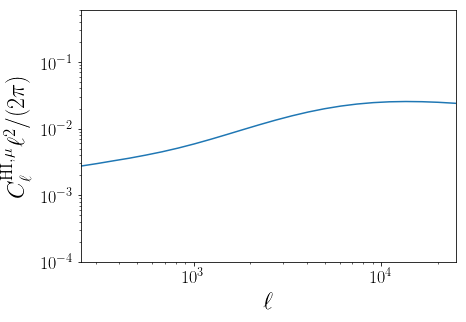

In [8]:
#plot it:
fig = P.figure(); ax = fig.add_subplot(111);

ax.loglog(ltab, Cl_Hxm_tab*ltab**2 / 2 / pi, label = "HI x mag")
# ax.loglog(ltab, Cl_gxm_tab*ltab**2 /2/ pi, label = "g x mag")

ax.set_xlabel("$\ell$")
ax.set_ylabel("$C_\ell^\mathrm{HI, \mu} \ell^2/(2\pi)$")

ax.set_xlim((250,25000))
ax.set_ylim((1e-4, 6e-1))
# ax.legend()
P.tight_layout()

P.savefig(plotdir + "HIxmag_Cls.pdf")

I think our $C_\ell^\mathrm{HI, mag}$ should match $C_\ell^{\mu g}$ Fig. 5 in Zhang&Pen almost, which it does! Both calculations from Alkistis' notes and following Z&P match. They are not exactly like in fig 5 because there they don't tell us what alpha they use exactly...

The main difference in the calculations is that Alkistis takes $s_g$ out of the integral, whereas in Z&P it's inside. As long as redshift bins are small I would not expect that to be significant.

[Their $\ell$ dependece is $C_\ell^{\mu g} \sim \Delta_m^2(\ell/r(z_f), z_f) / l^3$.

For us it's $C_\ell^\mathrm{HI, mag} \sim P((\ell + 1/2)/r(z),z))$.]

Next step: get error on gxmag

NOW: signal to noise!!!

In [9]:
#making new zf:

# zf = 0.9
# dzf = 0.05
zf = 1.1
dzf = 0.25
zb = 1.7
dzb = 0.2


lstart = 10; lend = 20000; 
lNN = 150
# ltab = np.linspace(lstart, lend, lNN, dtype = int)
ltab = np.unique(np.logspace(np.log10(lstart), np.log10(lend), lNN, dtype = int))
lN = len(ltab)
p_func_list = [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB]
powspeclist = [p_func_list[0](ltab, zfmin, zfmax),
               p_func_list[1](ltab, zbmin, zbmax),
               p_func_list[2](ltab, zf, dzf, zb, dzb)]
print "foreground from {} to {}".format(zf-dzf, zf+dzf)

print "background from {} to {}".format(zb-dzb, zb+dzb)


Caution, s_g is implemented without dependence on the experiment
foreground from 0.85 to 1.35
background from 1.5 to 1.9


In [10]:
# #check the different interferometer noises:

# Nell2 = Cl_interferom_noise_slow(ltab, zf -dzf, zf + dzf, hirax)
# Nell1 = Cl_interferom_noise(ltab, zf - dzf, zf + dzf, hirax)

# fig = P.figure(); ax = fig.add_subplot(111);
# # ax.loglog(ltab, Nell1)
# # ax.loglog(ltab, Nell2, ls = "--")
# ax.semilogx(ltab, Nell2/Nell1)
# ax.set_ylim((0.8,2))
# ax.set_xlabel(r"$\ell$")
# ax.set_ylabel("old noise / new noise")
# P.savefig(plotdir + "noisetest.pdf")

In [11]:
#without shot noise:
S2N_SKA = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=SKA)
S2N_HIRAX = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=hirax)
S2N_HIRAX512 = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=hirax512)
S2N_CV = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY="CV")

we assume d_ell = 1
We assume a perfect galaxy survey!
calculating single dish autocorrelation noise
we assume d_ell = 1
We assume a perfect galaxy survey!
calculating interferometer noise...
we assume d_ell = 1
We assume a perfect galaxy survey!
calculating interferometer noise...
we assume d_ell = 1


magmod.py:562: RuntimeWarning: overflow encountered in exp
  oneover_W_ell = np.exp( ltab**2 * sigb**2) #beam smoothing function.


In [12]:
#with shot noise:
S2N_SKA_LSST = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=[SKA, LSST])
S2N_HIRAX_LSST = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=[hirax, LSST])
S2N_HIRAX512_LSST = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=[hirax512, LSST])

we assume d_ell = 1
We use all sky for calculating N(z)
calculating single dish autocorrelation noise
we assume d_ell = 1
We use all sky for calculating N(z)
calculating interferometer noise...
we assume d_ell = 1
We use all sky for calculating N(z)
calculating interferometer noise...


In [13]:
# SKAcum = np.sqrt(np.array([np.sum( S2N_SKA[:i]**2) for i in range(len(S2N_SKA))]))
# cbHIRAXcum = np.sqrt(np.array([np.nansum( S2N_cbHIRAX[:i]**2) for i in range(len(S2N_cbHIRAX))]))
# cbHIRAX_LSSTcum = np.sqrt(np.array([np.nansum( S2N_cbHIRAX_LSST[:i]**2) for i in range(len(S2N_cbHIRAX_LSST))]))
# SKA_LSSTcum = np.sqrt(np.array([np.sum( S2N_SKA_LSST[:i]**2) for i in range(len(S2N_SKA_LSST))]))
# CVcum = np.sqrt(np.array([np.sum( S2N_CV[:i]**2) for i in range(len(S2N_CV))]))

(0.1, 15.592793974908282)

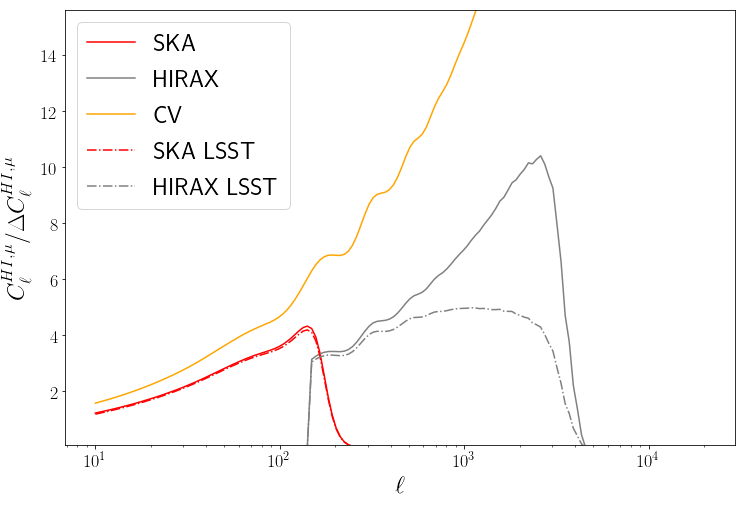

In [14]:
fig = P.figure(figsize = (12,8)); ax1 = fig.add_subplot(111); 

ax1.semilogx(ltab, S2N_SKA, label = "SKA", color = "red")
ax1.semilogx(ltab, S2N_HIRAX, label = "HIRAX", color = "grey")
ax1.semilogx(ltab, S2N_CV, label = "CV", color = "orange")

ax1.semilogx(ltab, S2N_SKA_LSST, label = "SKA LSST", color = "red", ls = "-.")
ax1.semilogx(ltab, S2N_HIRAX_LSST, label = "HIRAX LSST", color = "grey", ls = "-.")

ax1.set_ylabel("$C_\ell^{HI,\mu} / \Delta C_\ell^{HI,\mu} $")
ax1.set_xlabel("$\ell$")
ax1.legend(loc = "upper left")

ax1.set_ylim((0.1,1.5 * np.nanmax((S2N_HIRAX, S2N_SKA))))

# P.savefig(plotdir + "S2N.pdf")

Now playing around with the HIRAX redshift bin (using one bin at a time).
We want to see where the galaxy shot noise of the background starts to contribute similarly to the error of HIRAX. In the plot above clearly shot noise dominates the error, for example.

In [112]:
zbbmax = 2.5 #maximum range of LSST
zHIRAX_min = nutoz21(800) # minimum of HIRAX
# zHIRAX_max = nutoz21(400) # maximum of HIRAX
zHIRAX_max = 2. # maximum of HIRAX, more does not make sense otherwise we have no galaxies left to cross correlate with
# dzHIRAX = 0.05
dzHIRAX = 0.1
Nstep = np.int((zHIRAX_max - zHIRAX_min) / (2 * dzHIRAX))
print "HIRAX' z range: {} to {}".format(zHIRAX_min, zHIRAX_max)
zHIRAX_allbin, steplen = np.linspace(zHIRAX_min, zHIRAX_max, Nstep, retstep = True) #lower bin edges
zHIRAX_lowbin = zHIRAX_allbin[:-1]
dzHIRAX = steplen/2
zHIRAX_meanbin = zHIRAX_lowbin + dzHIRAX
zHIRAX_highbin = zHIRAX_lowbin + 2*dzHIRAX
NBIN = len(zHIRAX_lowbin)


S2Nlist_full = [] #1024 dishes
S2Nlist_512 = [] #512 dishes
zffli = []
# zbbli = []
# dzbli = []
for i in range(NBIN):
#     print zHIRAX_lowbin[i], zHIRAX_meanbin[i], zHIRAX_highbin[i]


    zff = zHIRAX_meanbin[i]
    zbbmin = zff + 2*dzHIRAX
    zbb = (zbbmin + zbbmax)/2
    dzbb = (zbbmax - zbbmin)/2
    dzbli.append(dzbb)
    zbbli.append(zbbmin)
    zffli.append(zff)
    powwwspeclist = [p_func_list[0](ltab, zff - dzHIRAX, zff + dzHIRAX),
                   p_func_list[1](ltab, zbbmin, zbbmax),
                   p_func_list[2](ltab, zff, dzHIRAX, zbb, dzbb)]
    
    print "BIN {}: \n using \t zf from {} to {}, \n and \t zb from {} to {}".format(i, zff-dzHIRAX, zff + dzHIRAX, 
                                                                                   zbbmin, zbbmax )
    S2Nlist_full.append( S2N(ltab, zff, dzHIRAX, zbb, dzbb, powwwspeclist, SURVEY=[hirax, LSST]) )
    S2Nlist_512.append( S2N(ltab, zff, dzHIRAX, zbb, dzbb, powwwspeclist, SURVEY=[hirax512, LSST]) )
    
    
# powspeclist = [p_func_list[0](ltab, zfmin, zfmax),
#                p_func_list[1](ltab, zbmin, zbmax),
#                p_func_list[2](ltab, zf, dzf, zb, dzb)]

HIRAX' z range: 0.7755075 to 2.0
Caution, s_g is implemented without dependence on the experiment
BIN 0: 
 using 	 zf from 0.7755075 to 1.020406, 
 and 	 zb from 1.14285525 to 2.5
we assume d_ell = 1
We use all sky for calculating N(z)
calculating interferometer noise...
we assume d_ell = 1
We use all sky for calculating N(z)
calculating interferometer noise...
Caution, s_g is implemented without dependence on the experiment
BIN 1: 
 using 	 zf from 1.020406 to 1.2653045, 
 and 	 zb from 1.38775375 to 2.5
we assume d_ell = 1
We use all sky for calculating N(z)
calculating interferometer noise...
we assume d_ell = 1
We use all sky for calculating N(z)
calculating interferometer noise...
Caution, s_g is implemented without dependence on the experiment
BIN 2: 
 using 	 zf from 1.2653045 to 1.510203, 
 and 	 zb from 1.63265225 to 2.5
we assume d_ell = 1
We use all sky for calculating N(z)
calculating interferometer noise...
we assume d_ell = 1
We use all sky for calculating N(z)
calculatin

(100.0, 10000.0)

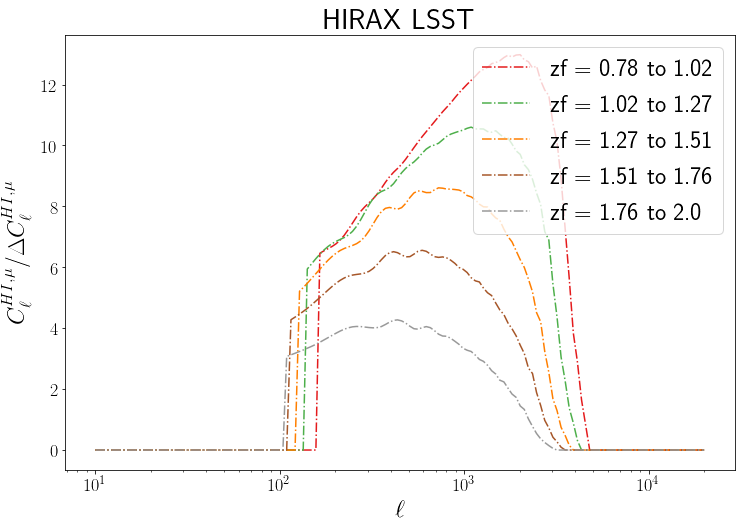

In [115]:
#plotting HIRAX for different binnings:

fig = P.figure(figsize = (12,8)); ax1 = fig.add_subplot(111); 

# ax1.semilogx(ltab, S2N_CV, label = "CV", color = "orange")

color_array = np.linspace(0,1, NBIN)

for i in range(NBIN):
    ci = color_array[i]
    zfmax_now = np.around(zffli[i] + dzHIRAX,2)
    zfmin_now = np.around(zffli[i] - dzHIRAX,2)
    ax1.semilogx(ltab, S2Nlist_full[i], 
                 label = "zf = {} to {}".format(zfmin_now, zfmax_now),
                 color=P.cm.Set1(ci), ls = "-.")
#                  color=P.cm.RdYlBu(ci), ls = "-.")
#     ax1.semilogx(ltab, S2Nlist_512[i], 
#                  color = P.cm.RdYlBu(ci), ls = ":")

ax1.set_ylabel("$C_\ell^{HI,\mu} / \Delta C_\ell^{HI,\mu} $")
ax1.set_xlabel("$\ell$")
ax1.legend(loc = "upper right")
ax1.set_title("HIRAX LSST")
# ax1.set_ylim((0,10))
ax.set_xlim((1e2, 1e4))

# P.savefig(plotdir + "S2N_HIRAX.pdf")

In [116]:
# fig = P.figure(figsize = (12,8)); ax1 = fig.add_subplot(111); 


# ax1.semilogx(ltab, CVcum, color = "orange", label = "CV")
# ax1.semilogx(ltab, cbHIRAXcum, color = "black", label = "HIRAX")
# ax1.semilogx(ltab, cbHIRAX_LSSTcum, ls = "-.", color = "black", label = "HIRAX LSST")
# ax1.semilogx(ltab, SKAcum, color = "red", label = "SKA")
# ax1.semilogx(ltab, SKA_LSSTcum, ls = "-.", color = "red", label = "SKA LSST")

# ax1.set_ylabel("$\mathrm{cum~} S/N$")
# ax1.set_xlabel("$\ell$")
# # ax1.legend(loc = "upper left")

# ax1.set_ylim((0.1,1.5 * np.amax((SKAcum, cbHIRAXcum))))
# P.savefig(plotdir + "cum_S2N.pdf")

This does not look bad! But we should check the noise calculations! I feel like the signal to noise is really high (maybe too high).

TODO:

-- look again at $s_g$... does this depend on our instrument??

-- Sort out the sky coverage issue when combingin HI and galaxy surveys (figure out the overlap of SKA/HIRAX with LSST)

-- Shot noise calculation might be wrong, I am unsure.

-- Interferometer noise might be wrong, I am unsure.

-- Single dish noise and beam should be okay, but we should check

# --Most importantly get something to check the noise calculations!

To check the noise here are a few plots that show the different contributions:

In [117]:
#look at different error contributions

#first get the 3 different signals:
Xsignal = powspeclist[2]
hsignal = powspeclist[0]
gsignal = powspeclist[1]

In [118]:
#now for CV
cverr = DELTA_Cl_HIxmag(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY = "CV")
#for HIRAX
HIRAXerr = DELTA_Cl_HIxmag(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY = [hirax, LSST])
#for SKA:
SKAerr = DELTA_Cl_HIxmag(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY = [SKA, LSST])

#LSST shot noise:
LSSTshot = shotnoise(zb, dzb, LSST, NINT = 200)

#HIRAX N_ell
HIRAXNell = Cl_interferom_noise(ltab,zf-dzf,zf+dzf, hirax)

#SKA N_ell
SKANell = noise_cls_single_dish(ltab, ztonu21(zf), SKA, 256)

we assume d_ell = 1
we assume d_ell = 1
We use all sky for calculating N(z)
calculating interferometer noise...
we assume d_ell = 1
We use all sky for calculating N(z)
calculating single dish autocorrelation noise
We use all sky for calculating N(z)


In [119]:
fsky_hirax = hirax["S_area"] /4/np.pi
fsky_SKA = SKA["S_area"] /4/np.pi


####cosmic variances:

SKACV_factor = 1/np.sqrt((2*ltab + 1) * fsky_SKA)
HIRAXCV_factor = 1/np.sqrt((2*ltab + 1) * fsky_hirax)
#cross:
XCVSKA = np.sqrt(Xsignal**2 + hsignal * gsignal) * SKACV_factor
XCVHIRAX = np.sqrt(Xsignal**2 + hsignal * gsignal) *HIRAXCV_factor
#HI:
HICVSKA = hsignal * SKACV_factor
HICVHIRAX = hsignal * HIRAXCV_factor
#gal:
GCVSKA = gsignal * SKACV_factor
GCVHIRAX = gsignal * HIRAXCV_factor

#noise contribution in the cross power spectrum:
XnoiseSKA = np.sqrt(hsignal*LSSTshot + gsignal*SKANell + LSSTshot*SKANell)
XnoiseHIRAX = np.sqrt(hsignal*LSSTshot + gsignal*HIRAXNell + LSSTshot*HIRAXNell)

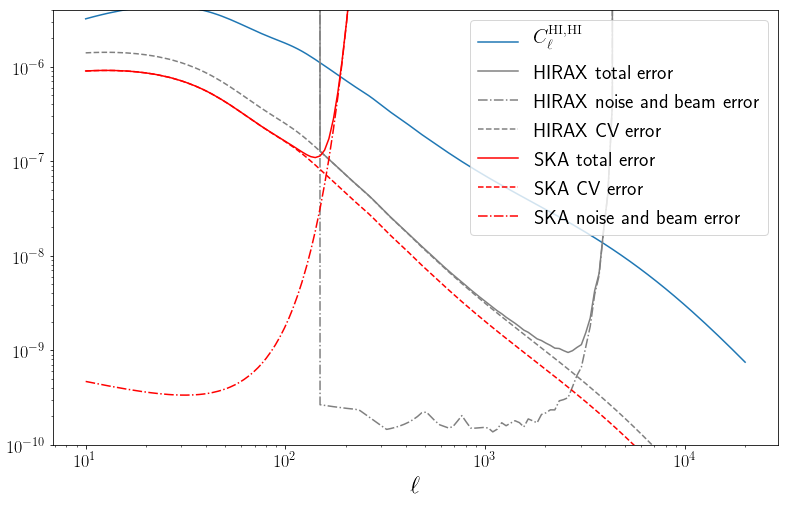

In [120]:
#first all for HI,HI power spectrum:

fig = P.figure(figsize = (13,8)); ax = fig.add_subplot(111);
ax.loglog(ltab, hsignal, label = r"$C_\ell^\mathrm{HI, HI}$")

ax.loglog(ltab, (hsignal + HIRAXNell) * HIRAXCV_factor, label = "HIRAX total error", color = "grey")
ax.loglog(ltab, HIRAXNell * HIRAXCV_factor, label = r"HIRAX noise and beam error", color = "grey", ls = "-.")
ax.loglog(ltab, HICVHIRAX, label = "HIRAX CV error", color = 'grey', ls = "--")


ax.loglog(ltab, (hsignal + SKANell) * SKACV_factor, label = "SKA total error", color = 'red')
ax.loglog(ltab, HICVSKA, label = "SKA CV error", color = 'red', ls = "--")
ax.loglog(ltab, SKANell * SKACV_factor, label = r"SKA noise and beam error", color = "red", ls = "-.")

ax.set_ylim((1e-10,4e-6))

ax.set_xlabel(r"$\ell$")
P.legend(fontsize = 20, loc = "upper right")

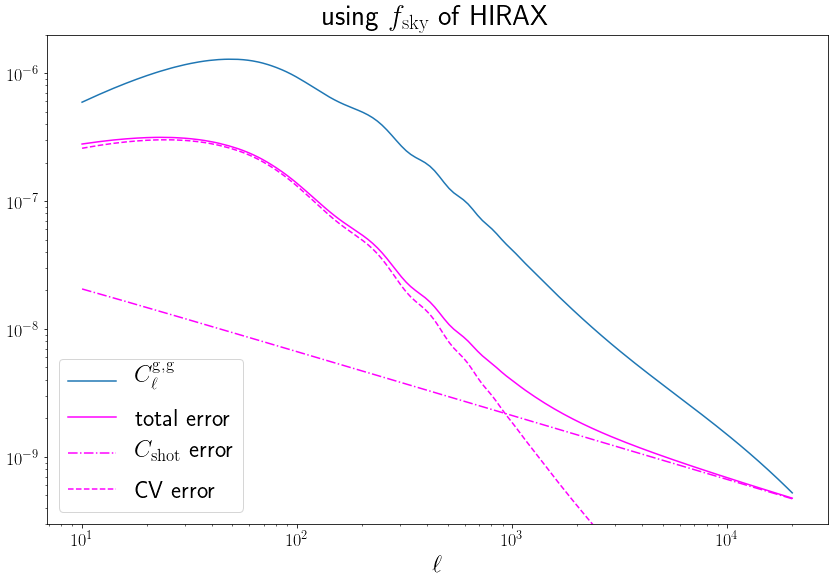

In [121]:
#now for galaxies:

#first all for HI,HI power spectrum:

fig = P.figure(figsize = (14,9)); ax = fig.add_subplot(111);
ax.loglog(ltab, gsignal, label = r"$C_\ell^\mathrm{g, g}$")

ax.loglog(ltab, (gsignal + LSSTshot) * HIRAXCV_factor, label = "total error", color = "magenta")
ax.loglog(ltab, LSSTshot * HIRAXCV_factor, label = r" $C_\mathrm{shot}$ error", color = "magenta", ls = "-.")
ax.loglog(ltab, GCVHIRAX, label = "CV error", color = 'magenta', ls = "--")
ax.set_title(r"using $f_\mathrm{sky}$ of HIRAX")

ax.set_ylim((3e-10, 2e-6))
ax.set_xlabel(r"$\ell$")
P.legend(loc = "lower left")

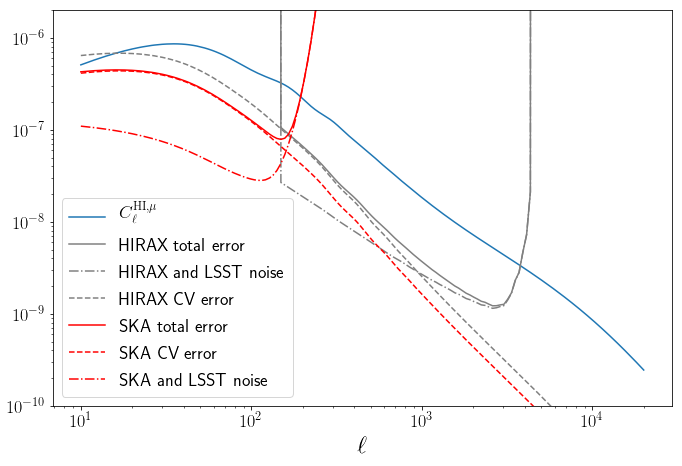

In [122]:
#last but not least the HIxmag power spectrum:

fig = P.figure(figsize = (10,7)); ax = fig.add_subplot(111);
ax.loglog(ltab, Xsignal, label = r"$C_\ell^{\mathrm{HI}, \mu}$")

ax.loglog(ltab, HIRAXerr, label = "HIRAX total error", color = "grey")
ax.loglog(ltab, XnoiseHIRAX * HIRAXCV_factor, label = "HIRAX and LSST noise", color = "grey", ls = "-.")
ax.loglog(ltab, XCVHIRAX, label = "HIRAX CV error", color = 'grey', ls = "--")


ax.loglog(ltab, SKAerr, label = "SKA total error", color = 'red')
ax.loglog(ltab, XCVSKA, label = "SKA CV error", color = 'red', ls = "--")
ax.loglog(ltab, XnoiseSKA * SKACV_factor, label = "SKA and LSST noise", color = "red", ls = "-.")

ax.set_xlabel(r"$\ell$")
P.legend(fontsize = 18, loc = "lower left")
ax.set_ylim((1e-10,2e-6))

P.tight_layout()
# P.savefig(plotdir + "X_error_contributions.pdf")